# Short history


* 15.04.2020:   
Первый сабмит   
Лучший скор на паблике: 0.37576
* 16.04.2020:   
Добавлено заполнение NaN'ов типа топлива   
Лучший скор на паблике: 0.47171   
* 17.04.2020:   
Улучшено заполнение пропусков: количество мест/дверей   
Добавлен новый признак: средняя цена марки/модели   
Лучший скор на паблике: 0.47742  
* 18.04.2020:   
Заполние NaN'ов в рабочем объёме при помощи линейной регрессии   
Начало оптимизации гиперпараметров   
Лучший скор на паблике: 0.50071
* 19.04.2020:   
Попробовали нейросети, не получили достойного результата   
Лучший скор на паблике: 0.42646
* 20.04.2020:   
Начали использовать Байесовскую оптимизацию для определения гиперпараметров   
Лучший скор на паблике: 0.50715   
* 21.04.2020:   
Улучшили заполнение пропусков моделей: теперь модель случайно выбирается только из текущей марки  
Продолжили оптимизировать гиперпараметры   
Лучший скор на паблике: 0.50862 
* 22.04.2020:   
Улучшили заполнение пропусков моделей: теперь она предсказывается исходя из марки и параметров машины   
Продолжили оптимизировать гиперпараметры   
Лучший скор на паблике: 0.51347

# Import Libraries


In [ ]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import random
import copy 

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

!pip install catboost
import catboost
from catboost import CatBoostRegressor, Pool

!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

sns.set(rc={'figure.figsize':(16,8)})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# EDA

Давайте посмотрим на данные

In [ ]:
data = pd.read_csv("data_train.csv")
data.sample(5)

,Unnamed: 0,Марка,Модель,Год выпуска,Рабочий объем,Мощность двигателя,Тип топлива,Трансмиссия,Количество мест,Количество дверей,Пробег,Цена
144431,144431,volkswagen,golf,1998,1390.0,55.0,NaN,ручной,5.0,2.0,119743.70,28500
20994,20994,kia,sportage,2014,1685.0,85.0,NaN,ручной,5.0,5.0,20792.65,322600
32662,32662,volkswagen,golf,2009,1390.0,118.0,NaN,ручной,5.0,5.0,74575.00,187900
52154,52154,rover,NaN,2012,2179.0,110.0,NaN,ручной,5.0,5.0,101650.00,552000
56592,56592,ford,thunderbird,1962,6400.0,221.0,NaN,авто,NaN,2.0,95815.10,344100


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146012 entries, 0 to 146011
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          146012 non-null  int64  
 1   Марка               146012 non-null  object 
 2   Модель              110867 non-null  object 
 3   Год выпуска         146012 non-null  int64  
 4   Рабочий объем       133953 non-null  float64
 5   Мощность двигателя  146012 non-null  float64
 6   Тип топлива         55760 non-null   object 
 7   Трансмиссия         146012 non-null  object 
 8   Количество мест     122633 non-null  float64
 9   Количество дверей   135322 non-null  float64
 10  Пробег              146012 non-null  float64
 11  Цена                146012 non-null  int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 13.4+ MB


In [ ]:
data.describe()

,Unnamed: 0,Год выпуска,Рабочий объем,Мощность двигателя,Количество мест,Количество дверей,Пробег,Цена
count,146012.00000,146012.000000,133953.000000,146012.000000,122633.000000,135322.000000,146012.000000,1.460120e+05
mean,73005.50000,2008.726824,1900.935754,101.656179,4.861660,3.983846,87033.925524,2.617951e+05
std,42150.17809,25.998616,985.233202,50.264525,0.865884,0.961134,75049.601767,5.513408e+05
min,0.00000,0.000000,15.000000,10.000000,1.000000,1.000000,0.000000,3.200000e+03
25%,36502.75000,2006.000000,1400.000000,70.000000,5.000000,4.000000,21280.000000,9.580000e+04
50%,73005.50000,2011.000000,1798.000000,90.000000,5.000000,4.000000,75525.000000,1.975000e+05
75%,109508.25000,2014.000000,1998.000000,120.000000,5.000000,5.000000,134900.000000,3.357000e+05
max,146011.00000,2016.000000,32000.000000,766.000000,23.000000,54.000000,853100.000000,1.293750e+08


In [ ]:
data.isna().sum()

Unnamed: 0                0
Марка                     0
Модель                35145
Год выпуска               0
Рабочий объем         12059
Мощность двигателя        0
Тип топлива           90252
Трансмиссия               0
Количество мест       23379
Количество дверей     10690
Пробег                    0
Цена                      0
dtype: int64

Посмотрим на распределние параметров

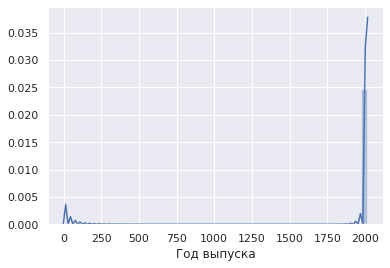

In [ ]:
sns.distplot(data["Год выпуска"])

На лицо явные выбросы, сделаем ограничение в 1930

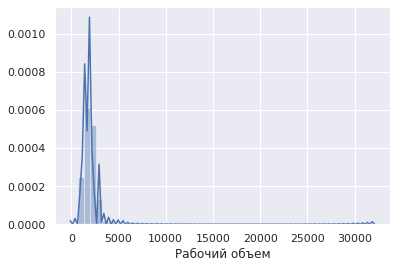

In [ ]:
sns.distplot(data["Рабочий объем"])

Снова выбросы. Граничное значение - что-то около 10000

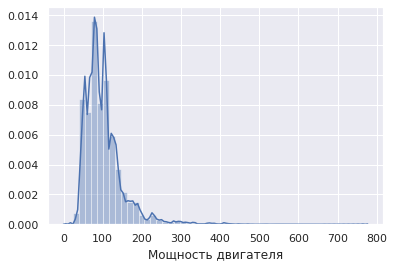

In [ ]:
sns.distplot(data["Мощность двигателя"])

Выбросы может и есть, но они не существенные, оставим как есть

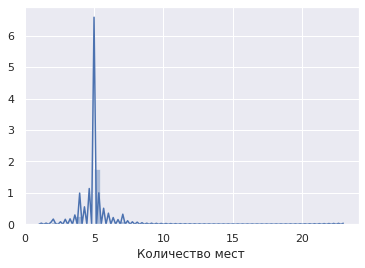

In [ ]:
sns.distplot(data["Количество мест"])

Есть значния, которые сильно отличаются от среднего, но такие значения вполне могут быть реальными

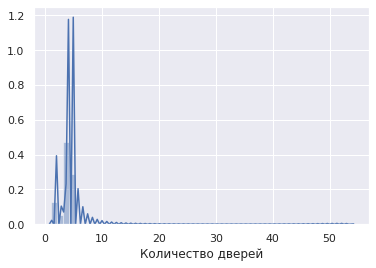

In [ ]:
sns.distplot(data["Количество дверей"])

Ну тут уже явно выбросы. Примерно на 10 проходит граница

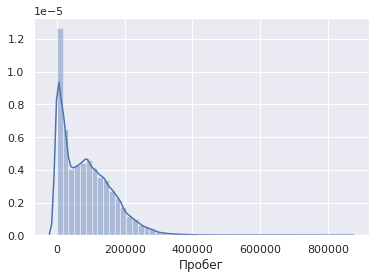

In [ ]:
sns.distplot(data["Пробег"])

Ну тут всё плюс-минус нормально

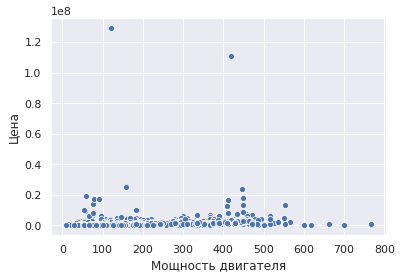

In [ ]:
# Давайте теперь посмотрим на зависимость Цены от мощности двигателя
sns.scatterplot(data["Мощность двигателя"], data["Цена"])

Тут видно, что по границе в 3e7 проходит разделение между просто редкими случаями высокой цены и выбросами

Гипотеза: Рабочий объем (примерно) линейно зависит от мощности двигателя

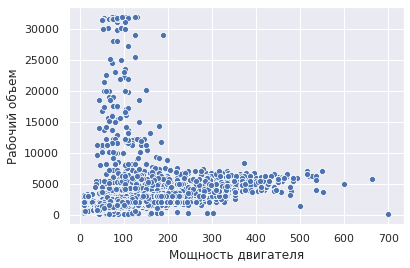

In [ ]:
sns.scatterplot(data["Мощность двигателя"], data["Рабочий объем"])

Да, видно линейную зависимость   
Значит NaN'ы в рабочем объеме можно заполнять линейной регрессией от мощности двигателя

In [ ]:
# Найдём нужные коэффициенты
train_data = pd.read_csv("data_train.csv").drop("Цена", axis=1)
test_data = pd.read_csv("data_test.csv")
train_test_data = pd.concat((train_data, test_data), ignore_index=True)

idx = ~pd.isna(train_test_data["Рабочий объем"])
X = train_test_data.loc[idx, "Мощность двигателя"].values.reshape(-1, 1)
X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
Y = train_test_data.loc[idx, "Рабочий объем"]

lin_reg = LinearRegression()
lin_reg.fit(X, Y)
lin_reg.coef_

array([11.66252849,  0.        ])

# Preprocessing


In [ ]:
# Получение информации о типах топлива для машин с разным уровнем мощности двигателя
def get_block_fuel(data):
    diesel_all = sum(data["Тип топлива"] == "дизель")
    petrol_all = sum(data["Тип топлива"] == "бензин")

    block_sz = 20
    block_cnt = 50

    data_block = data
    row_block = data_block.loc[:, ["Мощность двигателя"]].applymap(lambda p: min(p // block_sz, block_cnt-1))
    data_block.loc[:, "Блок"] = row_block.values
    block_fuel = data_block.groupby(["Блок", "Тип топлива"]).agg({"Мощность двигателя": "count"})

    for block in range(block_cnt):
        if not (block, "бензин") in block_fuel.index:
            block_fuel.loc[(block, "бензин"), "Мощность двигателя"] = 0
        if not (block, "дизель") in block_fuel.index:
            block_fuel.loc[(block, "дизель"), "Мощность двигателя"] = 0

    # [block][fuel_type]
    # fuel_type = 0 => petrol
    # fuel_type = 1 => diesel
    return block_fuel.values.reshape(-1, 2)

In [ ]:
# Мода количества мест и дверей в автомобиле данной модели
def get_model_info(data):
    idx = data[(~pd.isna(data["Количество дверей"]) & ~pd.isna("Количество мест"))].index
    data = data.loc[idx, :]

    seat_cnt = data.groupby(["Марка", "Модель"])["Количество мест"].apply(lambda x: x.mode())
    door_cnt = data.groupby(["Марка", "Модель"])["Количество дверей"].apply(lambda x: x.mode())

    model_info = pd.DataFrame({
        "Количество мест": seat_cnt,
        "Количество дверей": door_cnt,
    })

    model_info = model_info.droplevel(level=2)
    return model_info

In [ ]:
# Костыль
class MyPredictor:
    def __init__(self, value):
        self.value = value

    def predict(self, x):
        return self.value

car_info = ["Марка", "Рабочий объем", "Тип топлива", "Трансмиссия", "Количество мест", "Количество дверей"]

# Создание классификаторов для предсказания модели по характеристикам автомобиля
def get_mark_models(data):
    data = data.copy()
    data.dropna(inplace = True)
    model_by_brand_predictor = dict()

    for brand in data["Марка"].unique():
        X_labels = car_info
    
        X_cars = data.loc[data["Марка"] == brand, X_labels]
        Y_cars = data.loc[data["Марка"] == brand, "Модель"]

        predictor = catboost.CatBoostClassifier(cat_features=["Марка", "Тип топлива", "Трансмиссия"], iterations=100)
        if Y_cars.unique().shape[0] == 1:
            model_by_brand_predictor[brand] = MyPredictor(Y_cars.unique()[0])
            continue

        predictor.fit(X_cars, Y_cars, verbose=0)
        model_by_brand_predictor[brand] = predictor
    
    return model_by_brand_predictor

In [ ]:
# Средние значения цены для данной модели
def get_model_mean_price(data):
    return data.groupby(["Марка", "Модель"]).agg({"Цена": "mean"})

# Средние значения цены для данной марки
def get_brand_mean_price(data):
    return data.groupby("Марка").agg({"Цена": "mean"})

In [ ]:
# Загрузка обоих датасетов и их объединение
def get_train_test_data():
    train_data = pd.read_csv("data_train.csv").drop("Цена", axis=1)
    test_data = pd.read_csv("data_test.csv")

    return pd.concat((train_data, test_data), ignore_index=True)
 
train_test_data = get_train_test_data() 

# Получение информации о типах топлива для разных блоков
# и классификаторов для предсказания модели автомобиля
block_fuel = get_block_fuel(train_test_data)
model_by_brand = get_mark_models(train_test_data)

# Получение данных о средней цене марки/модели
# и данных о количестве мест/дверей для данной модели
train_data = pd.read_csv("data_train.csv")
model_mean_price = get_model_mean_price(train_data)
brand_mean_price = get_brand_mean_price(train_data)
model_info = get_model_info(train_data)

In [ ]:
# Заполнение NaN'ов "Тип топлива"
def fill_fuel_type_na(data):
    block_sz = 20
    block_cnt = 50

    idx = data[pd.isna(data["Тип топлива"])].index

    petrol_all = sum(data.loc[:, "Тип топлива"] == "бензин")
    diesel_all = sum(data.loc[:, "Тип топлива"] == "дизель")

    block_id = data.loc[idx, ["Мощность двигателя"]].applymap(lambda p: min(p // block_sz, block_cnt-1)).astype("int32")

    proba_a = block_id.applymap(lambda x: block_fuel[x][0] + block_fuel[x][1]) / (petrol_all + diesel_all)
    proba_a_b = block_id.applymap(lambda x: block_fuel[x][0]) / petrol_all
    proba_b = petrol_all / (petrol_all + diesel_all)

    filled_fuel = (proba_a_b * proba_b / proba_a).values.reshape(-1)

    filled_fuel = ["бензин" if x > 0.5 else "дизель" for x in filled_fuel]
    filled_fuel = np.array(filled_fuel)

    data.loc[idx, "Тип топлива"] = filled_fuel

    return data

# Заполнение NaN'ов "Количество мест"
def fill_seat_na(data):
    idx = data[pd.isna(data["Количество мест"])].index
    marks = data.loc[idx, "Марка"].values
    models = data.loc[idx, "Модель"].values

    pairs = zip(marks, models)
    f = lambda x: model_info.loc[x, "Количество мест"].values[0] if x in model_info.index else 5
    data.loc[idx, "Количество мест"] = list(map(f, pairs))

    idx = data[pd.isna(data["Количество мест"])].index
    data.loc[idx, "Количество мест"] = 5

    return data

# Заполнение NaN'ов "Количество дверей"
def fill_door_na(data):
    idx = data[pd.isna(data["Количество дверей"])].index
    marks = data.loc[idx, "Марка"].values
    models = data.loc[idx, "Модель"].values

    pairs = zip(marks, models)
    f = lambda x: model_info.loc[x, "Количество дверей"].values[0] if x in model_info.index else 4
    data.loc[idx, "Количество дверей"] = list(map(f, pairs))

    return data

# Заполение NaN'ов "Рабочий объем" по мощности двигателя
def fill_volume_na(data, coef = 11.66252849, bias = 0):
    idx = data[pd.isna(data["Рабочий объем"])].index
    data.loc[idx, "Рабочий объем"] = data.loc[idx, "Мощность двигателя"].values * coef + bias
    return data

# Заполнение NaN'ов "Модель"
def fill_model_na(data):
    idx = data[pd.isna(data["Модель"])].index
    fill_func = lambda x: model_by_brand[x[0]].predict(list(x))[0] if x[0] in model_by_brand else ""
    data.loc[idx, "Модель"] = data.loc[idx, car_info].apply(fill_func, axis=1).values

    return data

# Получение нового признака "Средняя цена модели"
def fill_mean_model_price(data):
    marks = data.loc[:, "Марка"].values
    models = data.loc[:, "Модель"].values

    pairs = zip(marks, models)
    f = lambda x: model_mean_price.loc[x, "Цена"] if x in model_mean_price.index else 2e5
    data.loc[:, "Средняя цена модели"] = list(map(f, pairs))

    return data

# Получение нового признака "Средняя цена марки"
def fill_mean_brand_price(data):
    f = lambda x: brand_mean_price.loc[x, "Цена"] if x in brand_mean_price.index else 2e5
    data.loc[:, "Средняя цена марки"] = data.loc[:, ["Марка"]].applymap(f).values

    return data

In [ ]:
# Препроцессинг данных
def prepare_data(data):
    cols = list(data.columns.copy())
    cols[0] = "Индекс"
    data.columns = cols

    # Заполнение NaN'ов
    data = fill_fuel_type_na(data)
    data = fill_door_na(data)
    data = fill_seat_na(data)
    data = fill_volume_na(data)
    data = fill_model_na(data)

    # Исправление выбросов
    data.loc[data["Рабочий объем"] > 10000, "Рабочий объем"] = 1798
    data.loc[data["Количество дверей"] > 10, "Количество дверей"] = 4
    data.loc[data["Год выпуска"] < 1930, "Год выпуска"] = 2010
    if "Цена" in data.columns:
        data.loc[data["Цена"] > 3e7, "Цена"] = 1e6

    # Добавление новых признаков
    data = fill_mean_model_price(data)
    data = fill_mean_brand_price(data)
    data.loc[:, "Лет с выпуска"] = 2020 - data["Год выпуска"]
    data.loc[:, "Багажник"] = data.loc[:, "Количество дверей"].astype("int32") % 2
    data.loc[:, "Интенсивность эксплуатации"] = data["Пробег"] / (data["Лет с выпуска"] + 1)
    data.loc[:, "Модель"] = data["Марка"] + " " + data["Модель"]

    # Удаление ненужных столбцов
    data.drop("Год выпуска", axis = 1, inplace = True)
    data.drop("Индекс", axis = 1, inplace = True)

    return data

# Получние признаков из датасета
def get_X(data):
    X_labels = ["Рабочий объем", "Мощность двигателя", "Тип топлива",
                "Трансмиссия", "Количество мест", "Количество дверей", "Пробег", 
                "Средняя цена модели", "Средняя цена марки", 
                "Лет с выпуска", "Багажник", "Интенсивность эксплуатации"]

    return data.loc[:, X_labels]

# Получение цен из датасета
def get_Y(data):
    Y_labels = ["Цена"]
    return data.loc[:, Y_labels]

# Категориальные признаки для CatBoost'а
cat_features = ["Тип топлива", "Трансмиссия"]

In [ ]:
# Загрузка и препроцессинг данных
data = pd.read_csv("data_train.csv")
data = prepare_data(data)
data.sample(5)

,Марка,Модель,Рабочий объем,Мощность двигателя,Тип топлива,Трансмиссия,Количество мест,Количество дверей,Пробег,Цена,Средняя цена модели,Средняя цена марки,Лет с выпуска,Багажник,Интенсивность эксплуатации
102963,fiat,fiat freemont,1956.0,125.0,дизель,авто,7.0,5.0,19.0,526000.0,346579.699248,153673.656375,5,1,3.166667
131403,citroen,citroen c1,998.0,50.0,бензин,ручной,4.0,5.0,58862.0,107600.0,108470.441989,159050.344564,8,1,6540.222222
128546,nissan,nissan pathfinder,2991.0,170.0,дизель,авто,7.0,5.0,108015.0,412300.0,255032.203390,219273.389121,9,1,10801.500000
128610,mercedes-benz,mercedes-benz 190,1796.0,80.0,дизель,ручной,5.0,4.0,90250.0,275900.0,274724.778761,375464.676126,7,0,11281.250000
51177,fiat,fiat bravo,1368.0,88.0,дизель,ручной,5.0,5.0,55575.0,94900.0,104006.572770,153673.656375,12,1,4275.000000


# Model selection and Hyperparameters tuning

In [ ]:
# Функция для запуска кросс-валидации CatBoost'а на оптимизируемых гиперпараметрах
def run_cat_boost(depth, bagging_t, l2_leaf_reg):
    params = {
        "eval_metric": "R2",
        "iterations": 100, # Тут стоит 100, чтобы быстрее считалось при демонстрации, но на лучшем сабмите было 3200
        "verbose": False,
        "depth": int(round(depth)),
        "bagging_temperature": bagging_t,
        "l2_leaf_reg": l2_leaf_reg
    }

    scores = catboost.cv(
        Pool(get_X(data), get_Y(data), cat_features = cat_features),
        params,
        fold_count = 4
    )

    return np.max(scores['test-R2-mean'])

In [ ]:
# Пространство гиперпараметров
search_space = {
    "depth": (4, 10),
    "bagging_t": (0,10),
    "l2_leaf_reg": (0, 30)
}

optimizer = BayesianOptimization(run_cat_boost, search_space)
optimizer.maximize(init_points=2, n_iter=8)

|   iter    |  target   | bagging_t |   depth   | l2_lea... |
-------------------------------------------------------------
|  1        |  0.6003   |  4.481    |  5.26     |  12.57    |
|  2        |  0.5846   |  6.028    |  4.317    |  13.56    |
|  3        |  0.6024   |  0.0      |  10.0     |  30.0     |
|  4        |  0.651    |  10.0     |  10.0     |  0.0      |
|  5        |  0.651    |  0.0      |  10.0     |  0.0      |
|  6        |  0.6103   |  9.473    |  9.94     |  14.24    |
|  7        |  0.6216   |  0.2593   |  9.828    |  6.843    |
|  8        |  0.6031   |  0.08608  |  4.111    |  0.1887   |
|  9        |  0.6024   |  10.0     |  10.0     |  30.0     |
|  10       |  0.5796   |  0.1774   |  4.366    |  29.8     |


Другие модели:   
Мы попробовали нейросети на PyTorch, но они не дали приемлимого результата:   
0.42646 на публичном датасете   
И, как позже выяснилось, 0.41773 на закрытом датасете   
В целом, ожидаемый результат, так как на классических табличных данных градиентный бустинг работает лучше нейросетей   
Это оказалось мало по сравнению с CatBoost'ом и мы откзались от нейросетей

# Submission

In [ ]:
# Вспомогательная функция для сабмита
def make_submission(Model, fname = "Submission.csv"):
    test_data = pd.read_csv("data_test.csv")
    Id = test_data.iloc[:, 0]
    test_data = prepare_data(test_data)
    X_test = get_X(test_data)
    preds = Model.predict(X_test)
    Submission = pd.DataFrame({"Id": Id, "Price": preds})
    Submission.to_csv(fname, index=False)

In [ ]:
# Запустим алгоритм с делением на train/valid, чтобы узнать оптимальное число эпох
Model = CatBoostRegressor(
    cat_features = cat_features, eval_metric = "R2",
    iterations=3200, l2_leaf_reg=5.455, max_depth=5, bagging_temperature = 8.324
)

X, Y = get_X(data), get_Y(data)
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size = 0.15)
Model.fit(X, Y, use_best_model=True, eval_set=(X_valid, Y_valid))

0:	learn: 0.0269870	test: 0.0222556	best: 0.0222556 (0)	total: 31.2ms	remaining: 1m 39s
1:	learn: 0.0525061	test: 0.0428678	best: 0.0428678 (1)	total: 55ms	remaining: 1m 27s
2:	learn: 0.0761555	test: 0.0622789	best: 0.0622789 (2)	total: 79.4ms	remaining: 1m 24s
3:	learn: 0.0989589	test: 0.0812071	best: 0.0812071 (3)	total: 103ms	remaining: 1m 22s
4:	learn: 0.1206918	test: 0.0992279	best: 0.0992279 (4)	total: 128ms	remaining: 1m 21s
5:	learn: 0.1411052	test: 0.1161260	best: 0.1161260 (5)	total: 152ms	remaining: 1m 20s
6:	learn: 0.1608906	test: 0.1322085	best: 0.1322085 (6)	total: 176ms	remaining: 1m 20s
7:	learn: 0.1794659	test: 0.1477375	best: 0.1477375 (7)	total: 199ms	remaining: 1m 19s
8:	learn: 0.1975772	test: 0.1624008	best: 0.1624008 (8)	total: 223ms	remaining: 1m 18s
9:	learn: 0.2146122	test: 0.1762967	best: 0.1762967 (9)	total: 259ms	remaining: 1m 22s
10:	learn: 0.2309238	test: 0.1898546	best: 0.1898546 (10)	total: 291ms	remaining: 1m 24s
11:	learn: 0.2466899	test: 0.2025356	bes

In [ ]:
# Финальное обучение на всём наборе данных и сабмит
Model = CatBoostRegressor(
    cat_features = cat_features, eval_metric = "R2",
    iterations=3200, l2_leaf_reg=5.455, max_depth=5, bagging_temperature = 8.324
)

X, Y = get_X(data), get_Y(data)
Model.fit(X, Y)
make_submission(Model)

0:	learn: 0.0269870	total: 29ms	remaining: 1m 32s
1:	learn: 0.0525061	total: 52.2ms	remaining: 1m 23s
2:	learn: 0.0761555	total: 75.4ms	remaining: 1m 20s
3:	learn: 0.0989589	total: 98.5ms	remaining: 1m 18s
4:	learn: 0.1206918	total: 122ms	remaining: 1m 17s
5:	learn: 0.1411052	total: 149ms	remaining: 1m 19s
6:	learn: 0.1608906	total: 173ms	remaining: 1m 18s
7:	learn: 0.1794659	total: 196ms	remaining: 1m 18s
8:	learn: 0.1975772	total: 219ms	remaining: 1m 17s
9:	learn: 0.2146122	total: 248ms	remaining: 1m 19s
10:	learn: 0.2309238	total: 276ms	remaining: 1m 19s
11:	learn: 0.2466899	total: 304ms	remaining: 1m 20s
12:	learn: 0.2615389	total: 328ms	remaining: 1m 20s
13:	learn: 0.2751473	total: 351ms	remaining: 1m 19s
14:	learn: 0.2888219	total: 374ms	remaining: 1m 19s
15:	learn: 0.3025271	total: 398ms	remaining: 1m 19s
16:	learn: 0.3150775	total: 434ms	remaining: 1m 21s
17:	learn: 0.3273089	total: 463ms	remaining: 1m 21s
18:	learn: 0.3388186	total: 486ms	remaining: 1m 21s
19:	learn: 0.3493532

#  Conclusion

В целом, результаты такие:
1.   Для классических табличных данных градиентный бустинг - оптимальный вариант
2.   Важную роль играет работа с данными: очистка, заполнение NaN'ов. Именно данный пункт внёс наибольший вклад в скор
3.   Оптимизация гиперпараметров с помощью Байесовской оптимизации работает гибче и, в целом, эффективнее GridSearch'а
4.   Оптимизация гиперпараметров может немного улучшить скор в сравнении с дефолтными параметрами

